In [205]:
import seaborn as sns
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np

from dpp.data import load_from_kaggle


In [206]:
dataset_link = "shivamb/machine-predictive-maintenance-classification" # replace with your dataset link from Kaggle 
destination = "../data/raw"
dataset_name = dataset_link.split("/")[-1]

files = load_from_kaggle(
    dataset_link=dataset_link, 
    destination=destination,
    )

Destination directory '../data/raw\machine-predictive-maintenance-classification' already exists with files. Skipping download (replace=False).


In [207]:
files

['predictive_maintenance.csv']

In [208]:
df = pd.read_csv("/".join(["../data/raw/", dataset_name, files[0]]))
df.head()

,UDI,Product ID,Type,Air temperature [K],Process temperature [K],Rotational speed [rpm],Torque [Nm],Tool wear [min],Target,Failure Type
0,1,M14860,M,298.1,308.6,1551,42.8,0,0,No Failure
1,2,L47181,L,298.2,308.7,1408,46.3,3,0,No Failure
2,3,L47182,L,298.1,308.5,1498,49.4,5,0,No Failure
3,4,L47183,L,298.2,308.6,1433,39.5,7,0,No Failure
4,5,L47184,L,298.2,308.7,1408,40.0,9,0,No Failure


In [209]:
display(
    "Shape",
    df.shape,
    "Description",
    df.describe().round(2),
    "Duplicates",
    df.duplicated().sum(),
)


pd.DataFrame(
    {
        "Data Types": df.dtypes,
        "Missing Values": df.isnull().sum(),
        "Unique Values": df.nunique(),
        "Sample Values": [df[col].sample(3).tolist() for col in df.columns]
    })


'Shape'

(10000, 10)

'Description'

,UDI,Air temperature [K],Process temperature [K],Rotational speed [rpm],Torque [Nm],Tool wear [min],Target
count,10000.00,10000.0,10000.00,10000.00,10000.00,10000.00,10000.00
mean,5000.50,300.0,310.01,1538.78,39.99,107.95,0.03
std,2886.90,2.0,1.48,179.28,9.97,63.65,0.18
min,1.00,295.3,305.70,1168.00,3.80,0.00,0.00
25%,2500.75,298.3,308.80,1423.00,33.20,53.00,0.00
50%,5000.50,300.1,310.10,1503.00,40.10,108.00,0.00
75%,7500.25,301.5,311.10,1612.00,46.80,162.00,0.00
max,10000.00,304.5,313.80,2886.00,76.60,253.00,1.00


'Duplicates'

np.int64(0)

,Data Types,Missing Values,Unique Values,Sample Values
UDI,int64,0,10000,"[2298, 4926, 6113]"
Product ID,object,0,10000,"[L56278, L52407, L56987]"
Type,object,0,3,"[H, L, H]"
Air temperature [K],float64,0,93,"[301.0, 298.6, 297.4]"
Process temperature [K],float64,0,82,"[313.4, 310.5, 307.8]"
Rotational speed [rpm],int64,0,941,"[2232, 1687, 1374]"
Torque [Nm],float64,0,577,"[48.8, 55.1, 38.5]"
Tool wear [min],int64,0,246,"[128, 97, 174]"
Target,int64,0,2,"[0, 0, 0]"
Failure Type,object,0,6,"[No Failure, No Failure, No Failure]"


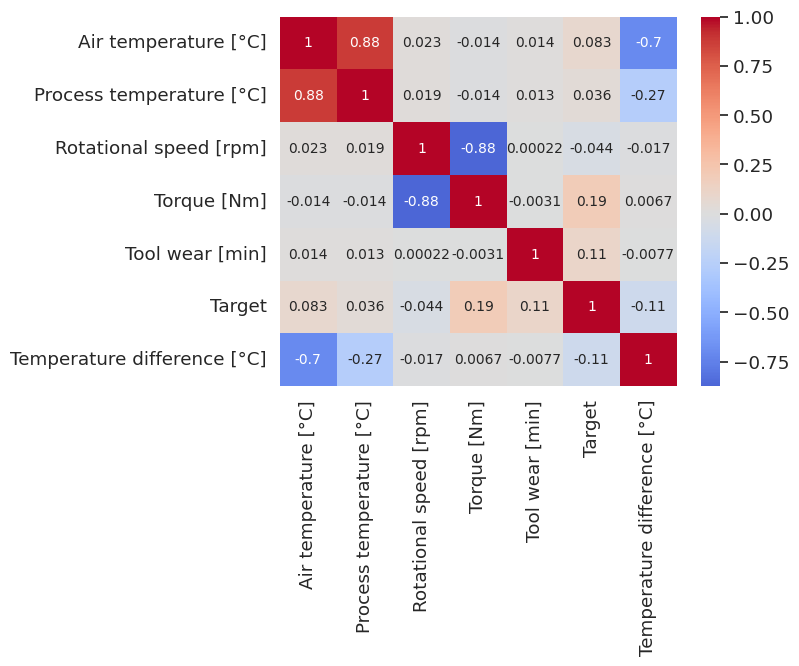

In [244]:
sns.heatmap(df.corr(numeric_only=True), annot=True, annot_kws={"size": 10}, cmap="coolwarm", center=0);


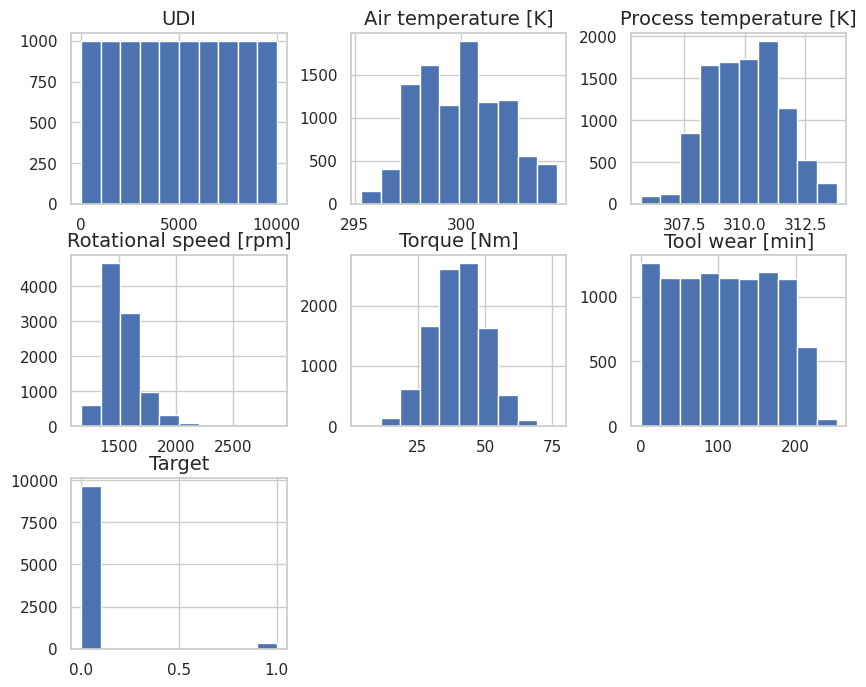

In [211]:
# Histogramm
df.hist(figsize=(10, 8))
plt.show()


In [212]:
print(df["Target"].unique())
print(df.dtypes)

[0 1]
UDI                          int64
Product ID                  object
Type                        object
Air temperature [K]        float64
Process temperature [K]    float64
Rotational speed [rpm]       int64
Torque [Nm]                float64
Tool wear [min]              int64
Target                       int64
Failure Type                object
dtype: object


In [248]:
# import warnings
# warnings.filterwarnings("ignore")

# sns.set_theme(palette='tab10',
#               font='Lucida Calligraphy',
#               font_scale=1.5,
#               rc=None)


# pd.set_option("display.max_columns",None)
# pd.set_option("display.max_rows",None)

import matplotlib
matplotlib.rcParams.update({'font.size': 15})

df = pd.read_csv("/".join(["../data/raw/", dataset_name, files[0]]))

df = df.drop(["UDI","Product ID"],axis=1)

df.sample(6)

,Type,Air temperature [K],Process temperature [K],Rotational speed [rpm],Torque [Nm],Tool wear [min],Target,Failure Type
3577,M,301.6,310.4,1455,39.0,118,0,No Failure
6886,M,300.8,311.3,1465,43.2,113,0,No Failure
5927,L,300.2,310.1,1649,30.5,43,0,No Failure
779,L,296.8,308.0,1666,29.8,41,0,No Failure
9710,L,299.1,310.1,1336,61.3,94,0,No Failure
3314,L,301.4,310.5,1489,43.5,98,0,No Failure


In [ ]:
# Converting temperature in centigrate from Kelvin [1 K = -272.15 °C  ] 

df["Air temperature [K]"] = df["Air temperature [K]"] - 272.15
df["Process temperature [K]"] = df["Process temperature [K]"] - 272.15

# Renaming temperature in Centigrate(°C) from Kelvin (K)
df.rename(columns={"Air temperature [K]" : "Air temperature [°C]","Process temperature [K]" : "Process temperature [°C]"},inplace=True)

In [216]:
df["Temperature difference [°C]"] = df["Process temperature [°C]"] - df["Air temperature [°C]"]
df.sample(5)

,Type,Air temperature [°C],Process temperature [°C],Rotational speed [rpm],Torque [Nm],Tool wear [min],Target,Failure Type,Temperature difference [°C]
7607,M,28.35,39.15,1468,41.1,34,0,No Failure,10.8
2357,L,27.15,36.35,1772,26.1,52,0,No Failure,9.2
7236,M,27.65,37.85,1460,37.1,169,0,No Failure,10.2
7138,L,28.45,37.95,1297,50.0,130,0,No Failure,9.5
2301,M,27.05,36.45,1586,35.7,138,0,No Failure,9.4


In [217]:
display(df.shape)
display(df.size)

(10000, 9)

90000

In [218]:
df.info() 

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10000 entries, 0 to 9999
Data columns (total 9 columns):
 #   Column                       Non-Null Count  Dtype  
---  ------                       --------------  -----  
 0   Type                         10000 non-null  object 
 1   Air temperature [°C]         10000 non-null  float64
 2   Process temperature [°C]     10000 non-null  float64
 3   Rotational speed [rpm]       10000 non-null  int64  
 4   Torque [Nm]                  10000 non-null  float64
 5   Tool wear [min]              10000 non-null  int64  
 6   Target                       10000 non-null  int64  
 7   Failure Type                 10000 non-null  object 
 8   Temperature difference [°C]  10000 non-null  float64
dtypes: float64(4), int64(3), object(2)
memory usage: 703.3+ KB


In [251]:
df.describe().style.background_gradient(cmap="viridis")

,Air temperature [K],Process temperature [K],Rotational speed [rpm],Torque [Nm],Tool wear [min],Target
count,10000.000000,10000.000000,10000.000000,10000.000000,10000.000000,10000.000000
mean,300.004930,310.005560,1538.776100,39.986910,107.951000,0.033900
std,2.000259,1.483734,179.284096,9.968934,63.654147,0.180981
min,295.300000,305.700000,1168.000000,3.800000,0.000000,0.000000
25%,298.300000,308.800000,1423.000000,33.200000,53.000000,0.000000
50%,300.100000,310.100000,1503.000000,40.100000,108.000000,0.000000
75%,301.500000,311.100000,1612.000000,46.800000,162.000000,0.000000
max,304.500000,313.800000,2886.000000,76.600000,253.000000,1.000000


In [220]:
# Anpassung Schrift
plt.rcParams['font.family'] = 'DejaVu Sans'    
plt.rcParams['font.size'] = 14
plt.rcParams['axes.labelweight'] = 'normal'
plt.rcParams['axes.labelsize'] = 14
plt.rcParams['axes.titlesize'] = 14




In [221]:
# Schrift in Seaborn anpassen
sns.set_theme(
    style="whitegrid",
    font="DejaVu Sans",
    rc={
        "font.size": 14,
        "axes.labelsize": 14,
        "axes.titlesize": 14
    }
)

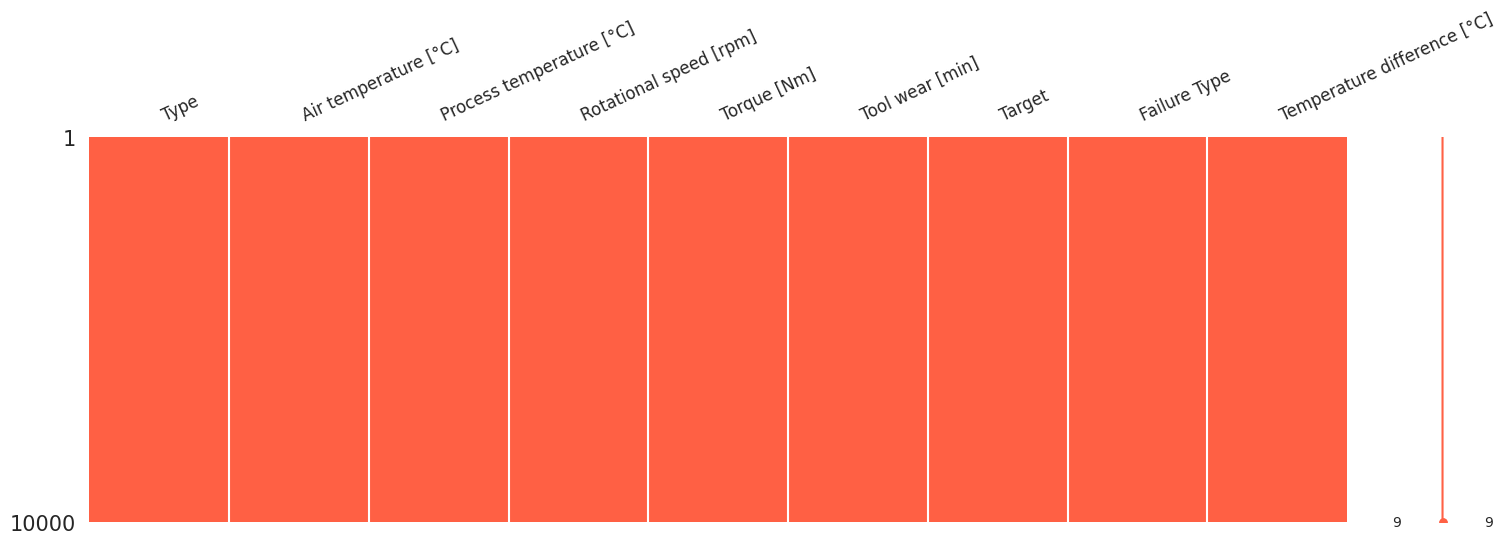

In [222]:
import missingno as msno
msno.matrix(df, figsize=(18,5), fontsize=12, color=(1, 0.38, 0.27));
plt.xticks(rotation=25);

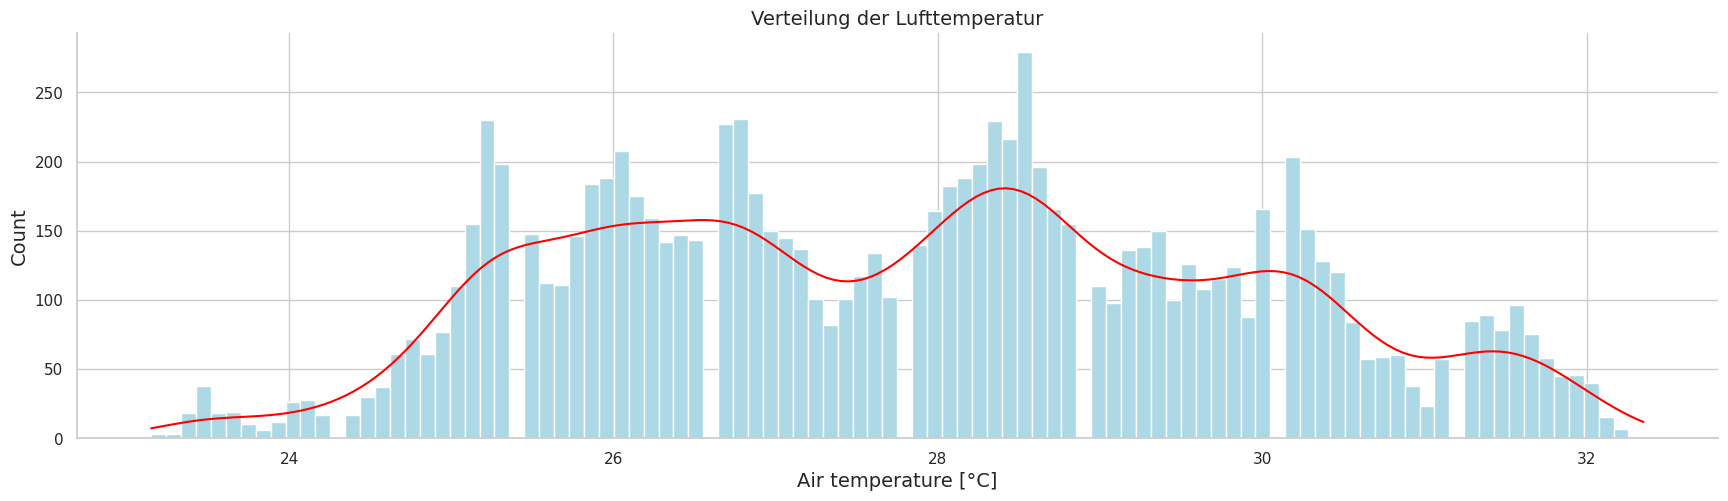

In [223]:
sns.displot(
    data=df, 
    x="Air temperature [°C]", 
    kde=True, 
    bins = 100,
    color = "red", 
    facecolor = "lightblue",
    height = 5, 
    aspect = 3.5
    );

plt.title("Verteilung der Lufttemperatur", fontsize=14)
plt.xlabel("Air temperature [°C]")
plt.ylabel("Count")

plt.show()


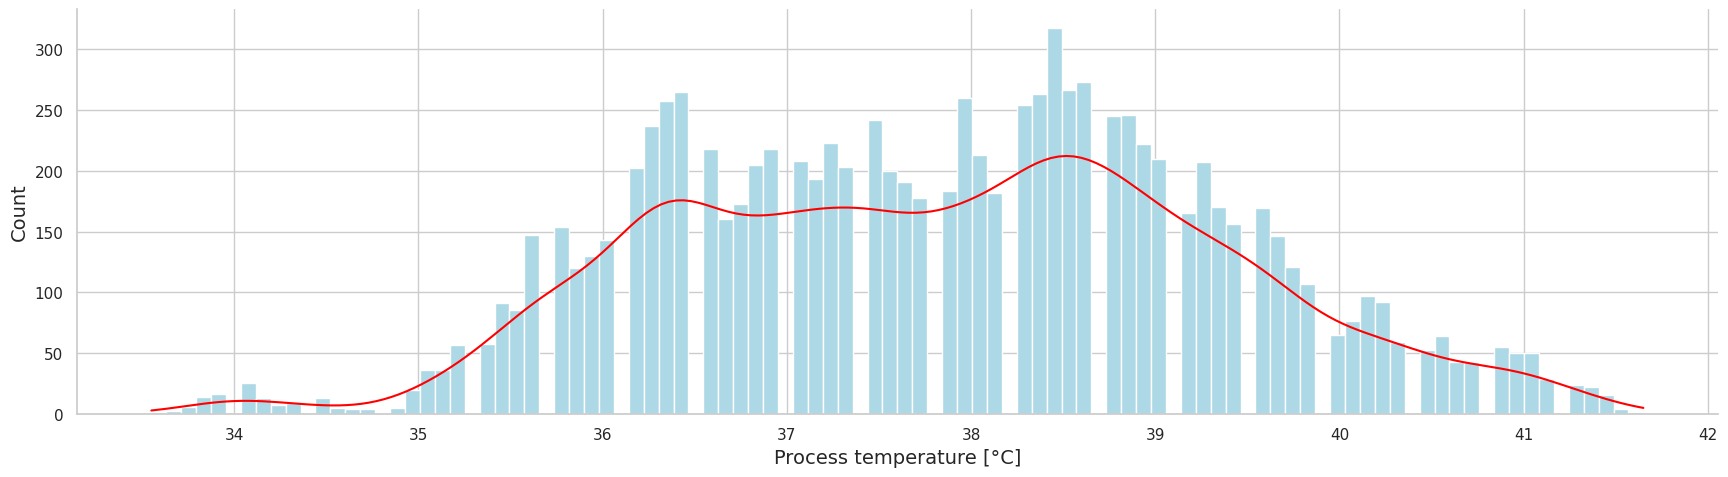

In [224]:
sns.displot(data=df, x="Process temperature [°C]", kde=True, bins = 100,color = "red", facecolor = "lightblue",height = 5, aspect = 3.5);

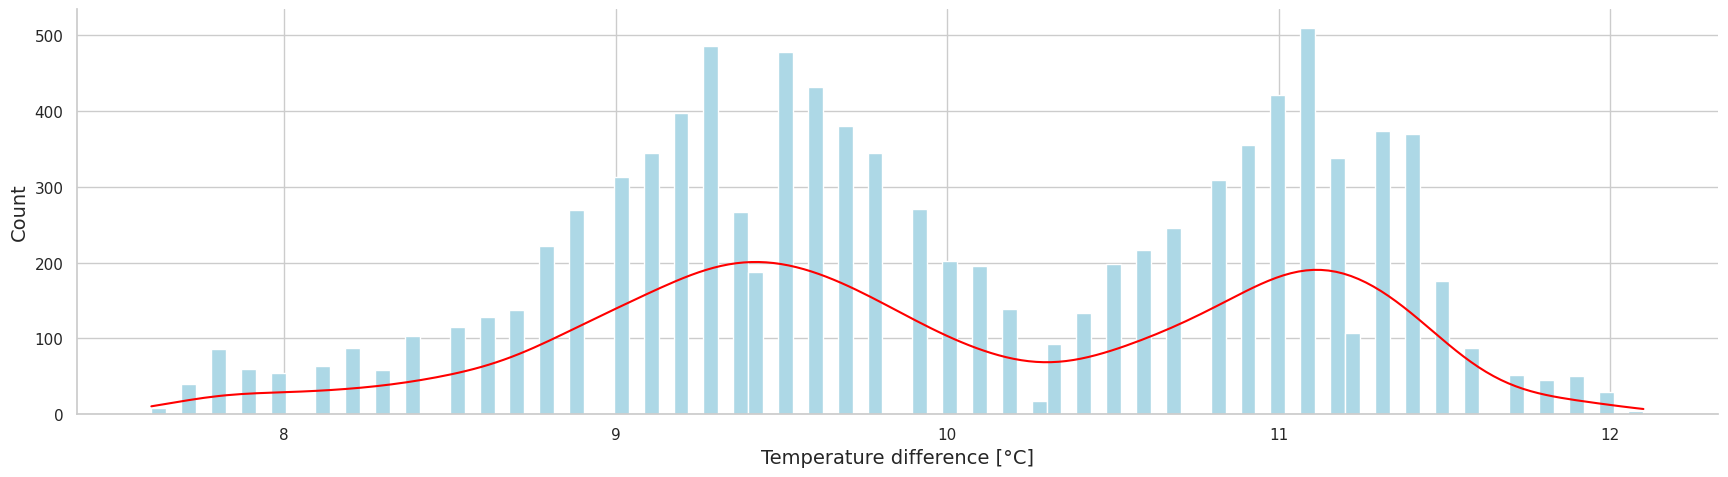

In [225]:
sns.displot(data=df, x="Temperature difference [°C]", kde=True, bins = 100,color = "red", facecolor = "lightblue",height = 5, aspect = 3.5);

In [226]:


for col in df[['Type','Target','Failure Type']]:
    print(df[col].value_counts()) 
    print("----"*8)



Type
L    6000
M    2997
H    1003
Name: count, dtype: int64
--------------------------------
Target
0    9661
1     339
Name: count, dtype: int64
--------------------------------
Failure Type
No Failure                  9652
Heat Dissipation Failure     112
Power Failure                 95
Overstrain Failure            78
Tool Wear Failure             45
Random Failures               18
Name: count, dtype: int64
--------------------------------


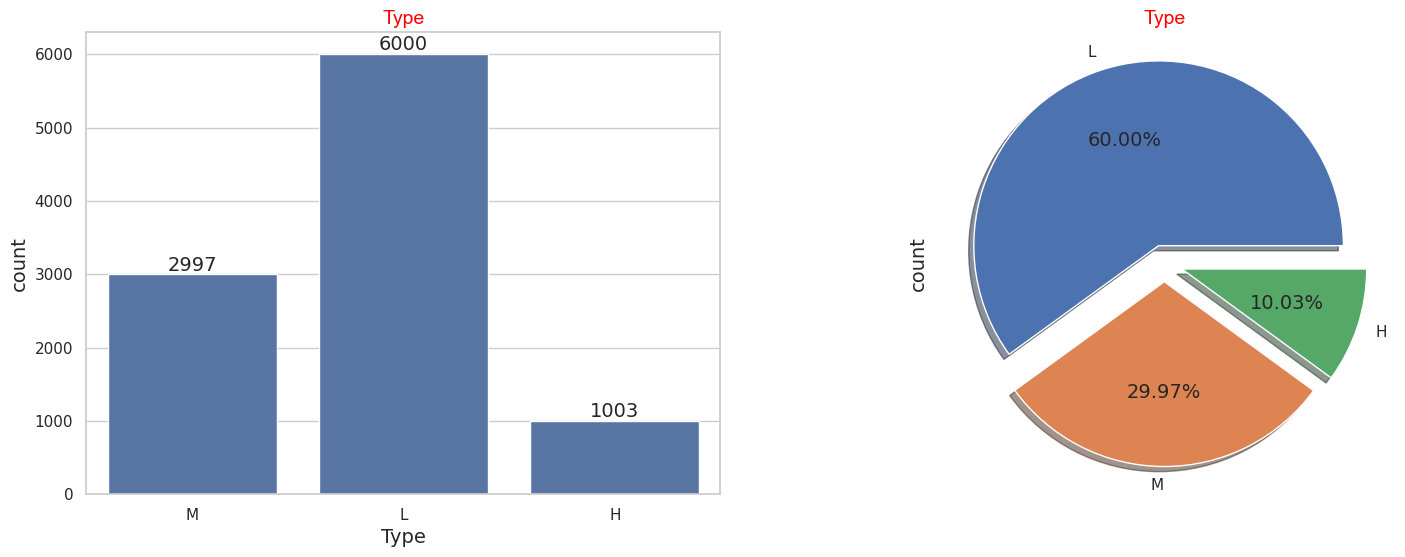

In [227]:
ax = plt.figure(figsize=(18,6))
ax = plt.subplot(1,2,1)
ax = sns.countplot(x='Type', data=df)
ax.bar_label(ax.containers[0])
plt.title("Type", fontsize=20,color='Red',font='Arial')
ax =plt.subplot(1,2,2)
ax=df['Type'].value_counts().plot.pie(explode=[0.1, 0.1,0.1],autopct='%1.2f%%',shadow=True);
ax.set_title(label = "Type", fontsize = 20,color='Red',font='Arial');

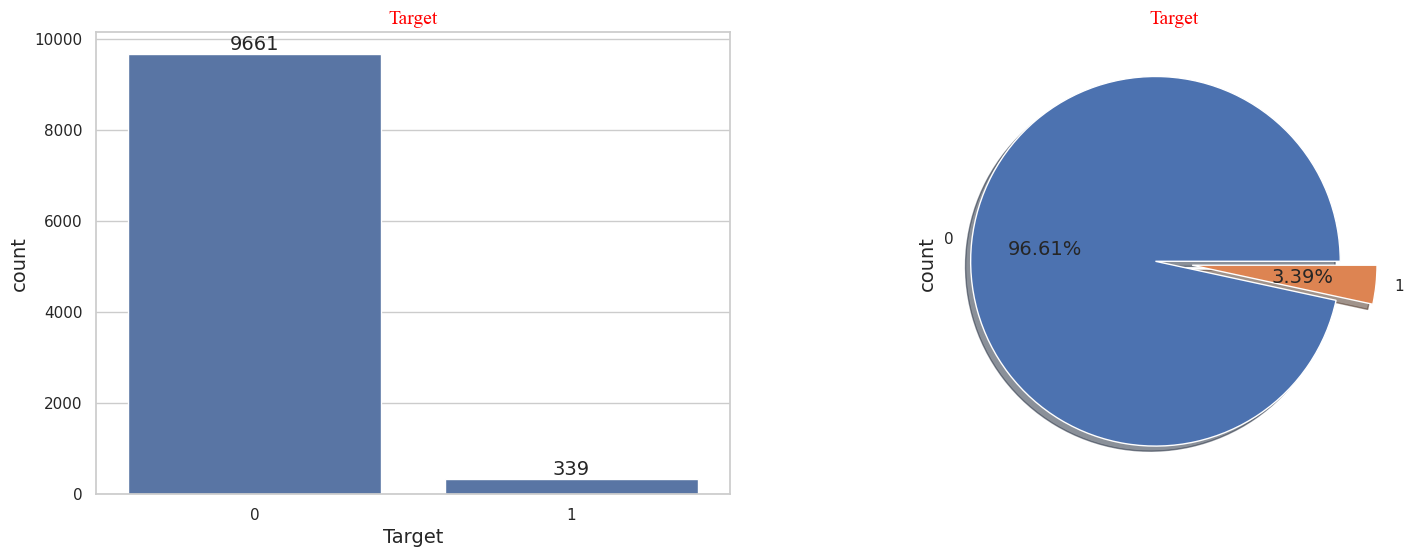

In [228]:
ax = plt.figure(figsize=(18,6))
ax = plt.subplot(1,2,1)
ax = sns.countplot(x='Target', data=df)
ax.bar_label(ax.containers[0])
plt.title("Target", fontsize=20,color='Red',font='Times New Roman')
ax =plt.subplot(1,2,2)
ax=df['Target'].value_counts().plot.pie(explode=[0.1, 0.1],autopct='%1.2f%%',shadow=True);
ax.set_title(label = "Target", fontsize = 20,color='Red',font='Times New Roman');


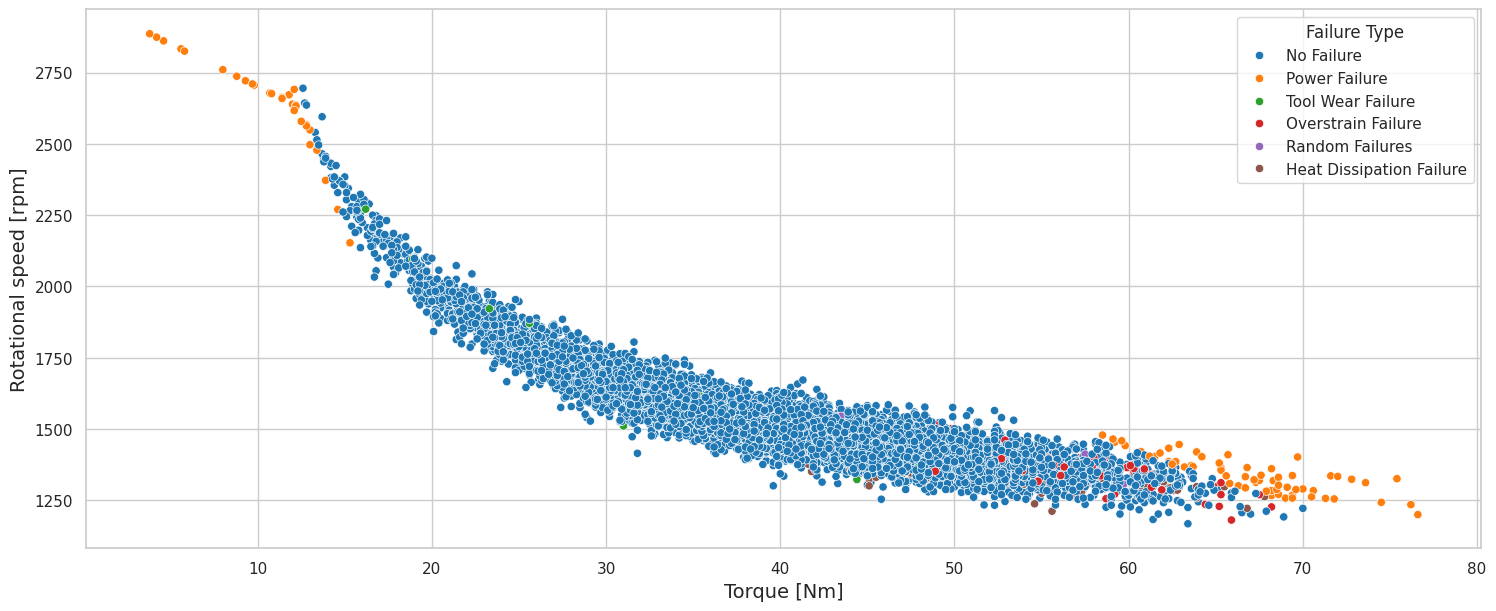

In [229]:

plt.figure(figsize=(18,7))
sns.scatterplot(data=df, x="Torque [Nm]", y="Rotational speed [rpm]", hue="Failure Type",palette="tab10");



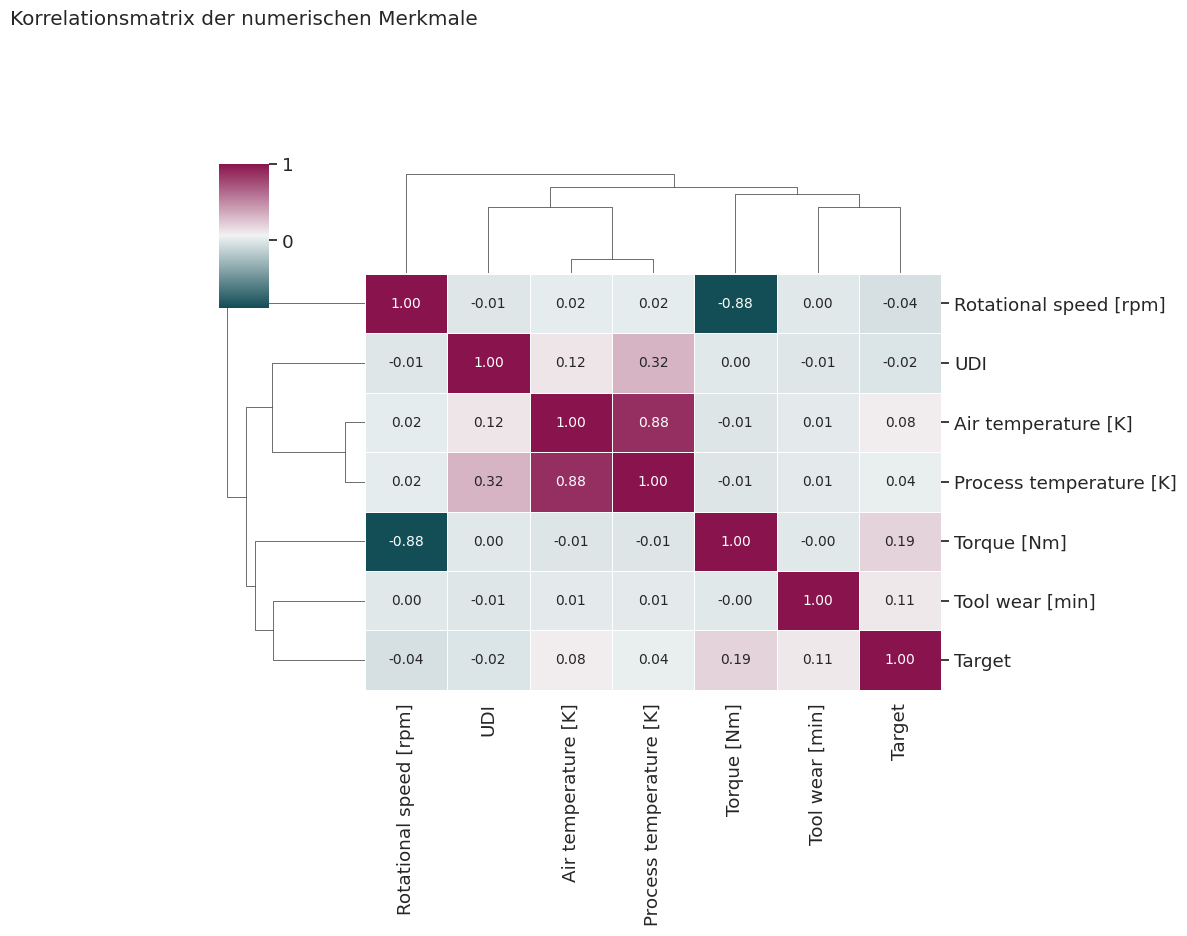

In [246]:
# Nur numerische Spalten auswählen
df_num = df.select_dtypes(include=['int64', 'float64'])

# Korrelationsmatrix berechnen
corr = df_num.corr()

# Schrift anpassen
sns.set_theme(style="white", font="DejaVu Sans", font_scale=1.2)

# Farbpalette definieren
cmap = sns.diverging_palette(210, 350, s=90, l=30, as_cmap=True)

# Clustermap zeichnen
sns.clustermap(
    corr,
    annot=True,       
    fmt=".2f",         
    cmap=cmap,          
    linewidths=0.5,     
    figsize=(10, 8),     
    annot_kws={"size": 10}
)

plt.title("Korrelationsmatrix der numerischen Merkmale", pad=100)
plt.show()

Unique Failure Types: ['No Failure' 'Power Failure' 'Tool Wear Failure' 'Overstrain Failure'
 'Random Failures' 'Heat Dissipation Failure']
                          precision    recall  f1-score   support

Heat Dissipation Failure       1.00      0.73      0.84        22
              No Failure       0.98      1.00      0.99      1930
      Overstrain Failure       1.00      0.50      0.67        16
           Power Failure       0.75      0.47      0.58        19
         Random Failures       0.00      0.00      0.00         4
       Tool Wear Failure       0.00      0.00      0.00         9

                accuracy                           0.98      2000
               macro avg       0.62      0.45      0.51      2000
            weighted avg       0.97      0.98      0.98      2000



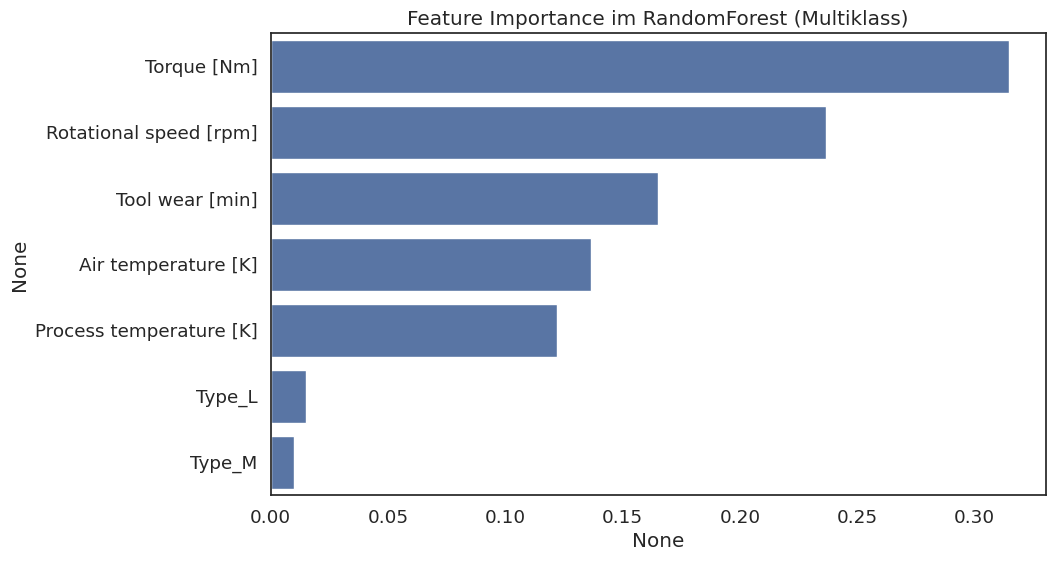

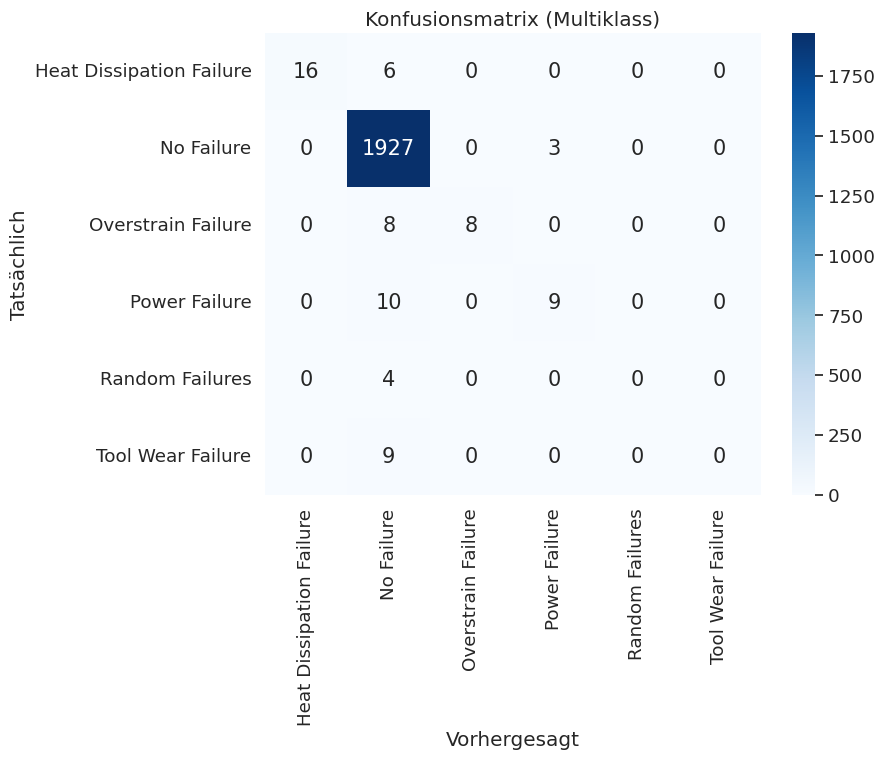

In [252]:
# Libraries laden
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import classification_report, confusion_matrix

# Dataset laden
#df = pd.read_csv("dataset/predictive_maintenance.csv")
df = pd.read_csv("/".join(["../data/raw/", dataset_name, files[0]]))

# Zielvariable = Failure Type (multiklass)
print("Unique Failure Types:", df["Failure Type"].unique())

# Strings in Zahlen umwandeln
le = LabelEncoder()
y = le.fit_transform(df["Failure Type"])

# Features vorbereiten
X = df.drop(["UDI", "Product ID", "Failure Type", "Target"], axis=1)

# Kategorische Spalte "Type" umwandeln
X = pd.get_dummies(X, columns=["Type"], drop_first=True)

# Train/Test Split
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42, stratify=y
)

# Modell trainieren
model = RandomForestClassifier(random_state=42)
model.fit(X_train, y_train)

# Vorhersagen
y_pred = model.predict(X_test)

# Report
print(classification_report(y_test, y_pred, target_names=le.classes_))

# Feature Importances
importances = pd.Series(model.feature_importances_, index=X.columns).sort_values(ascending=False)

plt.figure(figsize=(10,6))
sns.barplot(x=importances, y=importances.index)
plt.title("Feature Importance im RandomForest (Multiklass)")
plt.show()

# Konfusionsmatrix
cm = confusion_matrix(y_test, y_pred)
plt.figure(figsize=(8,6))
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues",
            xticklabels=le.classes_,
            yticklabels=le.classes_)
plt.title("Konfusionsmatrix (Multiklass)")
plt.xlabel("Vorhergesagt")
plt.ylabel("Tatsächlich")
plt.show()
